In [ ]:
%pip install s3fs

# Load Libraries

In [13]:
from sagemaker.feature_store.feature_group import FeatureGroup

import boto3
import sagemaker
import pandas as pd
import time
import datetime
from time import  strftime, gmtime
from sagemaker.session import Session

In [14]:
from sagemaker.feature_store.feature_store import FeatureStore

s3_client = boto3.client("s3")
sagemaker_session = sagemaker.Session()
boto_session = boto3.Session()
sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name
role = sagemaker.get_execution_role()

sagemaker_client = boto_session.client(service_name='sagemaker',
                                       region_name=region)

featurestore_runtime = boto_session.client(service_name='sagemaker-featurestore-runtime',
                                           region_name=region)

feature_store_session = Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_client,
    sagemaker_featurestore_runtime_client=featurestore_runtime
)

feature_store = FeatureStore(sagemaker_session=feature_store_session)

bucket_name = 'eliezerraj-908671954593-dataset'
prefix_name = 'payment-rcf/notebook'

print("---------------------------------")
pd.set_option('display.max_columns', 500)     # Make sure we can see all of the columns
pd.set_option('display.max_rows', 20)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
---------------------------------


In [15]:
payment_feature_group_name = 'payment-fraud-feature-group'

payment_feature_group = FeatureGroup(name=payment_feature_group_name,
                                     sagemaker_session=feature_store_session)

result_df, query = feature_store.create_dataset(
                               base=payment_feature_group,
                               output_path=data_location
).to_dataframe()

In [16]:
result_df.head(3)

,fraud,dt_payment,hour,distance,mcc,amount,tx_1d,avg_1d,tx_7d,avg_7d,tx_30d,avg_30d,time_btw_cc_tx,card_model_CHIP,card_model_VIRTUAL,card_type_CREDIT,EventTime
0,0,2024-05-07,20,14.866069,MOTOR,695.0,1,695.0,3,419.33,9,572.89,0,1,0,1,1.714787e+09
1,0,2024-03-11,15,55.326305,GIFT,123.0,1,123.0,3,133.67,14,499.79,0,0,1,1,1.714787e+09
2,0,2024-01-22,17,56.612719,COSMETIC,227.0,2,331.0,6,347.83,11,340.18,0,0,1,1,1.714787e+09


In [17]:
df_payment = result_df.filter(['fraud',
                                'amount',
                                'tx_1d',
                                'avg_1d',
                                'tx_7d',
                                'avg_7d',
                                'tx_30d',
                                'avg_30d',
                                'time_btw_cc_tx'], axis=1)

df_payment.head(3)

,fraud,amount,tx_1d,avg_1d,tx_7d,avg_7d,tx_30d,avg_30d,time_btw_cc_tx
0,0,695.0,1,695.0,3,419.33,9,572.89,0
1,0,123.0,1,123.0,3,133.67,14,499.79,0
2,0,227.0,2,331.0,6,347.83,11,340.18,0


# Build Model

In [18]:
# build model

from sagemaker import RandomCutForest

rcf = RandomCutForest(role=role,
                      instance_count=1,
                      instance_type='ml.m4.xlarge',
                      use_spot_instances=True,  # Use a spot instance 
                      max_run=300,  # Max training time
                      max_wait=600,  # Max training time + spot waiting time
                      #data_location=df_payment,
                      output_path='s3://{}/{}/{}/output'.format(bucket_name, prefix_name, "rcf-model"),
                      num_samples_per_tree=512,
                      num_trees=50)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [19]:
y = df_payment.to_numpy()

In [20]:
rcf.fit(rcf.record_set(y))

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: randomcutforest-2024-05-04-01-45-30-162


2024-05-04 01:45:30 Starting - Starting the training job...
2024-05-04 01:45:57 Starting - Preparing the instances for training......
2024-05-04 01:47:01 Downloading - Downloading the training image...............
2024-05-04 01:49:32 Training - Training image download completed. Training in progress....
2024-05-04 01:50:02 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:495: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cons['type'] is 'ineq':
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:743: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(self.X_min) is not 0:
[05/04/2024 01:49:53 INFO 140718486476608] Reading defaul

In [21]:
print('Training job name: {}'.format(rcf.latest_training_job.job_name))

Training job name: randomcutforest-2024-05-04-01-45-30-162


# Create a inference model

In [22]:
print("Progress:")
rcf_inference = rcf.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
)
print('Endpoint name: {}'.format(rcf_inference.endpoint_name))

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: randomcutforest-2024-05-04-01-53-59-562


Progress:


INFO:sagemaker:Creating endpoint-config with name randomcutforest-2024-05-04-01-53-59-562
INFO:sagemaker:Creating endpoint with name randomcutforest-2024-05-04-01-53-59-562


--------!Endpoint name: randomcutforest-2024-05-04-01-53-59-562


In [23]:
results = rcf_inference.predict(y)
scores = [datum.label["score"].float32_tensor.values[0] for datum in results]

results = df_payment.copy()
results["score"] = scores
results.head()

,fraud,amount,tx_1d,avg_1d,tx_7d,avg_7d,tx_30d,avg_30d,time_btw_cc_tx,score
0,0,695.0,1,695.0,3,419.33,9,572.89,0,0.837439
1,0,123.0,1,123.0,3,133.67,14,499.79,0,0.757118
2,0,227.0,2,331.0,6,347.83,11,340.18,0,0.652311
3,0,58.0,1,58.0,3,184.00,10,239.10,0,0.759621
4,0,231.0,2,326.5,2,326.50,10,256.40,383,0.753169


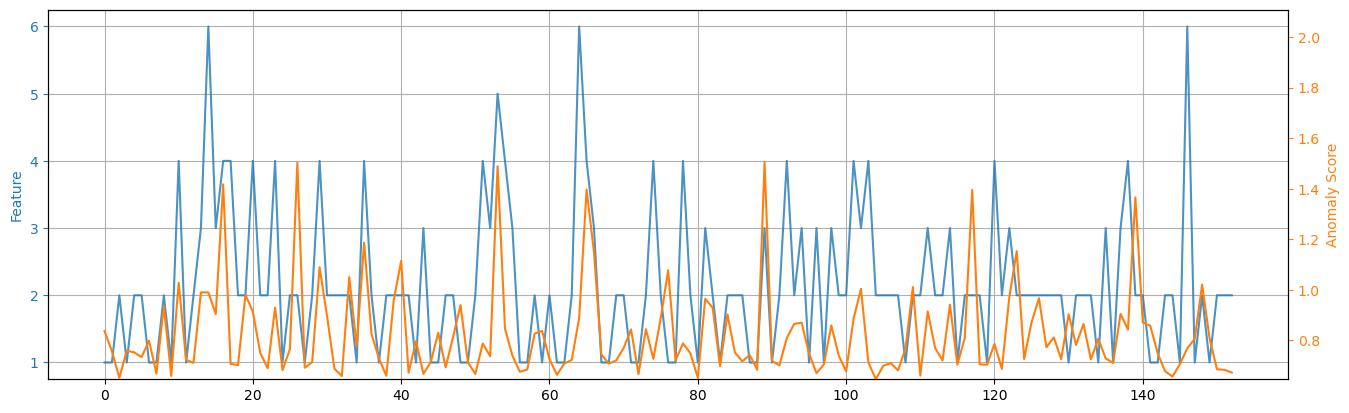

In [24]:
# graphs
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(results['tx_1d'], color='C0', alpha=0.8)
ax2.plot(results['score'], color='C1')

ax1.grid(which='major', axis='both')

ax1.set_ylabel('Feature', color='C0')
ax2.set_ylabel('Anomaly Score', color='C1')

ax1.tick_params('y', colors='C0')
ax2.tick_params('y', colors='C1')

ax2.set_ylim(min(scores), 1.4 * max(scores))
fig.set_figwidth(16)

score_mean = results['score'].mean()
score_std = results['score'].std()
score_cutoff = score_mean + 4 * score_std # adjust constant to tweak sensitivity

anomalies = results[results['score'] > score_cutoff]
ax2.plot(anomalies.index, anomalies.score, 'ko');

# New predicition

In [41]:
# new data
df_new_data = [{'fraud': 0, 
                        'amount': 1, 
                        'tx_1d': 1, 
                        'avg_1d': 1,
                        'tx_7d': 1,
                        'avg_7d': 1,
                        'tx_30d': 1,
                        'avg_30d': 1,
                        'time_btw_cc_tx': 1 }]

df_new_data = pd.DataFrame(df_new_data)
df_new_data

,fraud,amount,tx_1d,avg_1d,tx_7d,avg_7d,tx_30d,avg_30d,time_btw_cc_tx
0,0,1,1,1,1,1,1,1,1


In [45]:
new_y = df_new_data.to_numpy()
new_results = rcf_inference.predict(new_y)
new_scores = [datum.label["score"].float32_tensor.values[0] for datum in new_results]
new_scores

[0.8959877490997314]